<a href="https://colab.research.google.com/github/betyavan/ML-practice/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import skimage.io
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

Загрузка датасета

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [3]:
all_photos, all_attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


Simple VAE

In [4]:
features = 16
class LinearVAE(nn.Module):
  def __init__(self):
    super(LinearVAE, self).__init__()
    
    self.flatten = nn.Flatten()
    self.encoder = nn.Sequential(
        nn.Linear(12288, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 2 * features)
    )
    self.decoder = nn.Sequential(
        nn.Linear(features, 512),
        nn.ReLU(),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, 12288)
    )

  # reparametrization trick
  def reparametrize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    sample = mu + (eps * std)
    return sample

  def forward(self, x):
    # encoding
    x = self.flatten(x).float()
    x = self.encoder(x).view(-1, 2, features)

    mu = x[:, 0, :]
    log_var = x[:, 1, :]
    z = self.reparametrize(mu, log_var)
    # decoding
    x = self.decoder(z)
    reconstruction = torch.sigmoid(x)
    return reconstruction, mu, log_var

  def sample(self, z):
    generated = self.decoder(z)
    generated = torch.sigmoid(generated)
    generated = generated.view(-1, 64, 64, 3)
    return generated

  def get_latent_vector(self, x):
    x = self.flatten(x).float()
    x = self.encoder(x).view(-1, 2, features)
    mu = x[:, 0, :]
    log_var = x[:, 1, :]
    z = self.reparametrize(mu, log_var)
    return z

In [5]:
def KL_divergence(mu, logsigma):
  loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
  return loss

def log_likelihood(x, reconstruction):
  loss = nn.BCELoss(reduction='sum')
  return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
  return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Обучение

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = loss_vae
autoencoder = LinearVAE().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())

In [7]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(all_photos, all_attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

In [8]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          reconstruction, mu, logsigma = autoencoder(batch.to(device))
          reconstruction = reconstruction.view(-1, 64, 64, 3)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
autoencoder.eval()
with torch.no_grad():
  for batch in val_loader:
    reconstruction, mu, logsigma = autoencoder(batch.to(device))
    reconstruction = reconstruction.view(-1, 64, 64, 3)
    result = reconstruction.cpu().detach().numpy()
    ground_truth = batch.numpy()
    break

In [10]:
import matplotlib.pyplot as plt

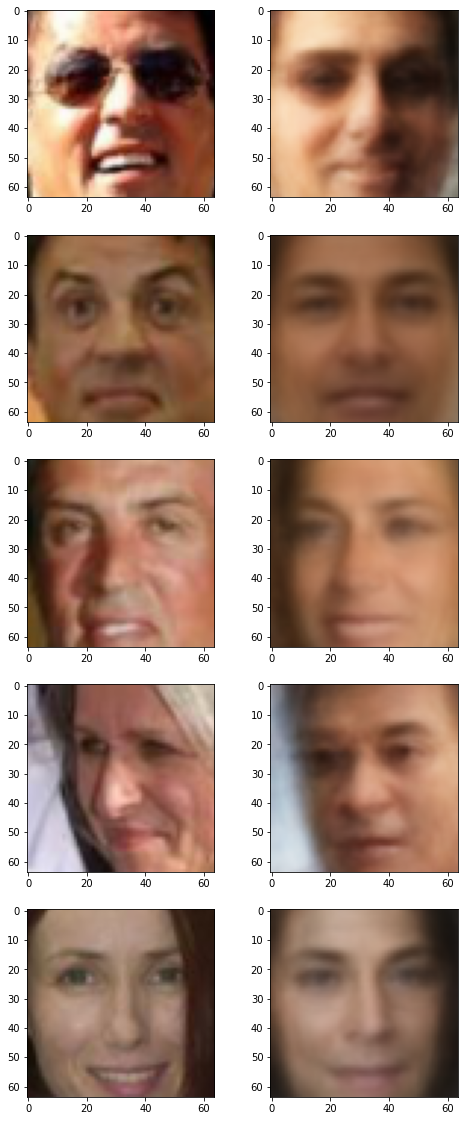

In [11]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

сэмплинг

In [12]:
z = np.array([np.random.normal(0, 1, features) for i in range(10)])
output = autoencoder.sample(torch.FloatTensor(z).to(device))

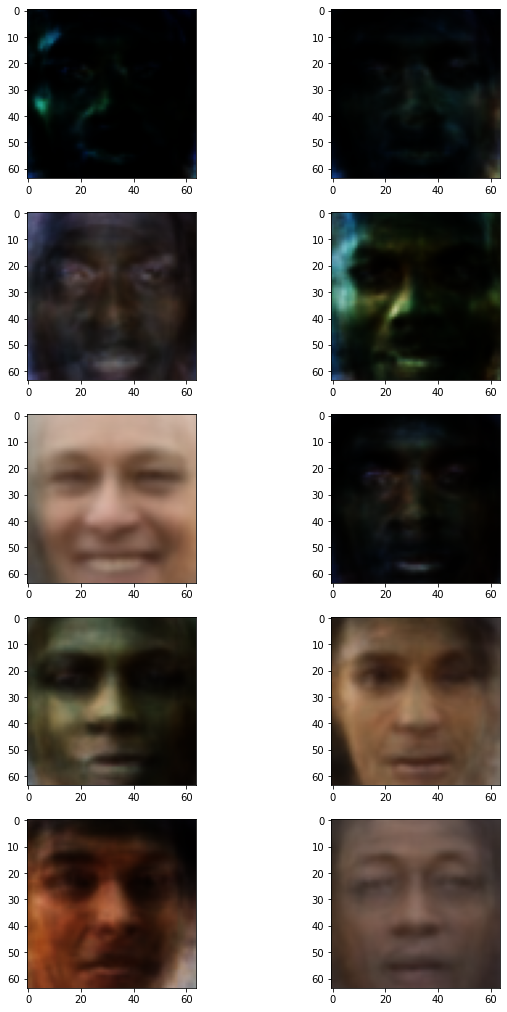

In [13]:
plt.figure(figsize=(10, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)

plt.show()

In [14]:
gt_0 = torch.FloatTensor([ground_truth[0]]).to(device)
gt_1 = torch.FloatTensor([ground_truth[1]]).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [15]:
first_latent_vector = autoencoder.get_latent_vector(gt_0)
second_latent_vector = autoencoder.get_latent_vector(gt_1)

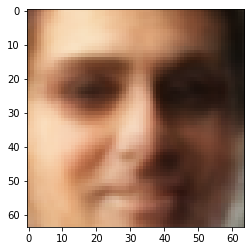

In [16]:
plt.imshow(autoencoder.sample(first_latent_vector)[0].cpu().detach().numpy())

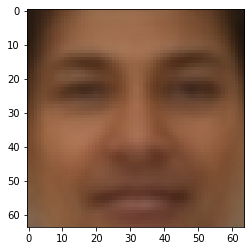

In [17]:
plt.imshow(autoencoder.sample(second_latent_vector)[0].cpu().detach().numpy())

выпуклая комбинация $\alpha l_1 + (1-\alpha)l_2$

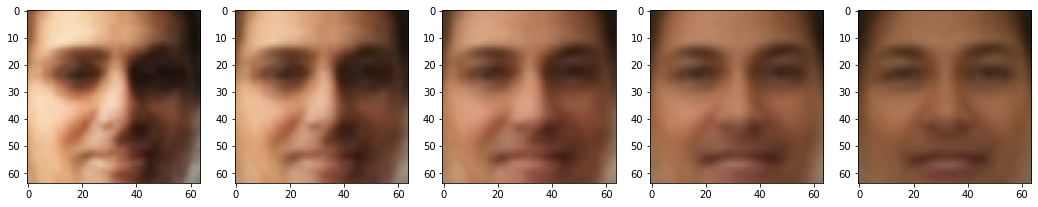

In [18]:
plt.figure(figsize=(18, 5))
for i, alpha in enumerate(np.linspace(0, 1, 5)):
  plt.subplot(1, 5, i+1)
  latent = (1-alpha)*first_latent_vector+alpha*second_latent_vector
  img = autoencoder.sample(latent)[0].cpu().detach().numpy()
  plt.imshow(img)